In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(6452, 24)
(6452, 3)


In [6]:
X_motion_CoM[0, :]

array([0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.24480174481868744,
       0.12290000170469284, -0.38674935698509216, 0.23840242624282837,
       -0.12859922647476196, -0.38087984919548035, -0.25725996494293213,
       0.12268177419900894, -0.3884574770927429, -0.25710463523864746,
       -0.12830162048339844, -0.38234463334083557, -0.0036863016430288553,
       -0.0004571790632326156, -0.043575383722782135,
       -0.01105028111487627, True, False], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(3238,)

In [10]:
X_motion_CoM_FL_RR[0, :]

array([0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.24480174481868744,
       0.12290000170469284, -0.38674935698509216, 0.23840242624282837,
       -0.12859922647476196, -0.38087984919548035, -0.25725996494293213,
       0.12268177419900894, -0.3884574770927429, -0.25710463523864746,
       -0.12830162048339844, -0.38234463334083557, -0.0036863016430288553,
       -0.0004571790632326156, -0.043575383722782135,
       -0.01105028111487627, True, False], dtype=object)

In [11]:
Y_motion_CoM_FL_RR[0, :]

array([0.003580319358261974, 0.0011485660802389441, 0.0013221883273787094],
      dtype=object)

## Predict CoM -> x

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))0.04954298

R2:  0.9768293905759118
RMSE:  0.009299674925121678
The lowest error is:  4.730672684416515e-06
The highest error is:  0.03344573994068212
The avg. error is:  0.007138004935764254


In [13]:
model_fl_com_x.coef_

array([[ 3.75912288e-03,  2.77555756e-17, -2.77555756e-17,
         5.62522559e-02, -5.20417043e-17, -5.55111512e-17,
         2.28846181e-01,  2.06211771e-01, -5.80364133e-02,
         1.05269232e-02, -6.29745107e-02,  9.39519728e-01,
        -1.22945273e-01, -1.86813648e-01, -2.00832418e-01,
         1.45324058e-01]])

In [14]:
model_fl_com_x.intercept_

array([0.11201191])

In [15]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16 is different from 14)

Text(0, 0.5, 'Predictions')

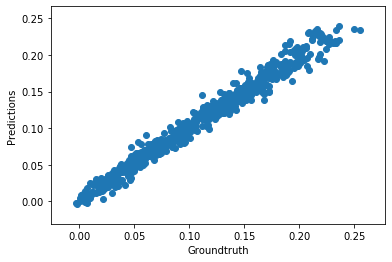

In [16]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
#%store model_fl_com_x

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.678097988411304
RMSE:  0.003011329384174015
The lowest error is:  5.727809289438057e-07
The highest error is:  0.009991281524859709
The avg. error is:  0.00228658883696215


In [21]:
model_fl_com_y.coef_

array([[ 2.96401104e-03,  9.36750677e-17,  5.89805982e-17,
        -1.13726129e-02, -2.77555756e-17,  4.16333634e-17,
         5.32170318e-02,  5.27727604e-02,  1.11655993e-01,
        -4.69088333e-01,  3.80951579e-02,  5.13672519e-02,
        -2.06511399e-01,  1.76229731e-01, -6.59591462e-02,
         2.99767591e-03]])

In [22]:
model_fl_com_y.intercept_

array([-0.06230189])

Text(0, 0.5, 'Predictions')

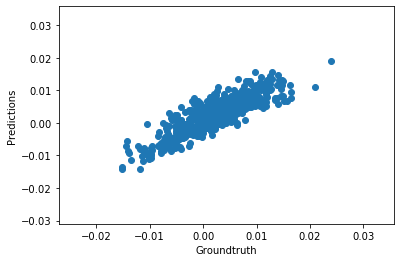

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [24]:
#%store model_fl_com_y

In [25]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [26]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [27]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, 3:6], # Current motion command
               X_motion_CoM_FL_RR[:, 18:20], # Current CoM (x,y) veloctiy
               X_motion_CoM_FL_RR[:, 6:8], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 12:14], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 15:17])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.4191421341472461
RMSE:  0.0021911685857165376
The lowest error is:  2.3477106323790964e-06
The highest error is:  0.010074713308328709
The avg. error is:  0.0017014468422110556


In [31]:
model_fl_com_theta.coef_

array([[-9.69819437e-04, -1.73472348e-18,  5.20417043e-18,
         1.46323355e-04, -2.51534904e-17,  1.38777878e-17,
        -9.42565404e-03, -1.22945547e-02,  3.14725519e-03,
        -2.01648295e-02,  1.03209771e-02,  2.25842390e-02,
         3.17088871e-02, -1.28863230e-01,  5.18945449e-02,
         5.57207858e-02]])

In [32]:
model_fl_com_theta.intercept_

array([0.04966778])

Text(0, 0.5, 'Predictions')

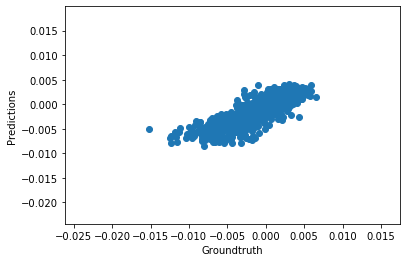

In [30]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")